In [12]:
# @title parte 1: cargar el archivo


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import io
import warnings
warnings.filterwarnings('ignore')

from google.colab import files

uploaded = files.upload()

print("archivos subido:")
for filename in uploaded.keys():
    print(f"  • {filename} ({len(uploaded[filename])} bytes)")


Saving precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera.csv to precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera (2).csv
archivos subido:
  • precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera (2).csv (622389 bytes)


Saving precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera.csv to precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera (1).csv
archivos subido:
  • precipitacion_2026enero__Medellin_AeropuertoEnriqueOlayaHerrera (1).csv (622389 bytes)


In [13]:

# @title parte 1: lectura inicial

filename = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[filename]), sep=';', decimal=',')


print(f"total de registros originales: {len(df):,}")
print(f" Variables: {list(df.columns)}")
print(f"\n primeras 5 filas:")
print(df.head())
print(f"\n ultimas 5 filas:")
print(df.tail())
print(f"\n tipos de datos:")
print(df.dtypes)
print(f"\n valores nulos por columna:")
print(df.isnull().sum())


total de registros originales: 24,102
 Variables: ['FechaObservacion', 'ValorObservado']

 primeras 5 filas:
          FechaObservacion  ValorObservado
0  2026 Jan 01 01:00:00 AM             0.0
1  2026 Jan 01 01:00:00 PM             0.0
2  2026 Jan 01 01:02:00 AM             0.0
3  2026 Jan 01 01:02:00 PM             0.0
4  2026 Jan 01 01:04:00 AM             0.0

 ultimas 5 filas:
              FechaObservacion  ValorObservado
24097  2026 Jan 28 08:10:00 PM            1.95
24098  2026 Jan 30 09:30:00 PM            2.84
24099       12/1/2026 21:00:00            2.97
24100       12/1/2026 00:10:00            3.37
24101  2026 Jan 03 05:20:00 AM            4.02

 tipos de datos:
FechaObservacion     object
ValorObservado      float64
dtype: object

 valores nulos por columna:
FechaObservacion    0
ValorObservado      0
dtype: int64


In [22]:
# @title parte 1: procesamiento de los datos

# 1. formato a las fechas
df['FechaObservacion'] = pd.to_datetime(df['FechaObservacion'], errors='coerce', dayfirst=True)
print(f" \n  Fechas convertidas. Registros con fecha inválida: {df['FechaObservacion'].isnull().sum()}")

# 2. eliminar filas con fechas invalidas
df_original = df.copy()
df = df.dropna(subset=['FechaObservacion'])
print(f"   registros después de eliminar fechas inválidas: {len(df):,}")

# 3. eliminar duplicados exactos
print("\n2. bscando duplicados exactos...")
duplicados_exactos = df[df.duplicated()]
print(f"   duplicados exactos encontrados: {len(duplicados_exactos):,}")
df = df.drop_duplicates()
print(f"   registros después de eliminar duplicados exactos: {len(df):,}")

# 4. eliminar duplicados temporales (misma fecha/hora, diferente valor)
print("\n3. buscando duplicados temporales...")
# Ordenar datos
df = df.sort_values(by=['FechaObservacion', 'ValorObservado'])
# Contar duplicados temporales
duplicados_temporales = df[df.duplicated(subset=['FechaObservacion'], keep=False)]
print(f"   registros con duplicados temporales: {len(duplicados_temporales):,}")
# Mantener el de menor valor
df = df.drop_duplicates(subset=['FechaObservacion'], keep='first')
print(f"   registros después de eliminar duplicados temporales: {len(df):,}")

# Ordenar por fecha
df = df.sort_values('FechaObservacion').reset_index(drop=True)

# Resultados esperados
print("\n RESULTADOS ")
print(f"Total registros resultantes: {len(df):,}")
print(f"Total duplicados exactos eliminados: {len(duplicados_exactos):,}")
print(f"Total duplicados temporales eliminados: {len(duplicados_temporales) - len(duplicados_temporales.drop_duplicates(subset=['FechaObservacion'])):,}")

# Mediciones diferentes de cero
mediciones_no_cero = df[df['ValorObservado'] > 0]['ValorObservado']
if len(mediciones_no_cero) > 0:
    print(f"\n Mediciones diferentes de cero:")
    print(f"   Mínima: {mediciones_no_cero.min():.2f} mm")
    print(f"   Máxima: {mediciones_no_cero.max():.2f} mm")
    print(f"   Moda (más frecuente): {mediciones_no_cero.mode().values[0]:.3f} mm")
    print(f"   Conteo: {len(mediciones_no_cero):,} registros")
else:
    print("\n no hay mediciones diferentes de cero")

 
  Fechas convertidas. Registros con fecha inválida: 0
   registros después de eliminar fechas inválidas: 16,428

2. bscando duplicados exactos...
   duplicados exactos encontrados: 0
   registros después de eliminar duplicados exactos: 16,428

3. buscando duplicados temporales...
   registros con duplicados temporales: 0
   registros después de eliminar duplicados temporales: 16,428

 RESULTADOS 
Total registros resultantes: 16,428
Total duplicados exactos eliminados: 0
Total duplicados temporales eliminados: 0

 Mediciones diferentes de cero:
   Mínima: 0.00 mm
   Máxima: 2.81 mm
   Moda (más frecuente): 0.014 mm
   Conteo: 1,038 registros


In [9]:

# @title parte 2: Identificar máxima temporada seca

# ordenar por fecha
df = df.sort_values('FechaObservacion').reset_index(drop=True)

# diferencia entre mediciones consecutivas
df['DiffSegundos'] = df['FechaObservacion'].diff().dt.total_seconds()
df['DiffMinutos'] = df['DiffSegundos'] / 60

# identificar gaps mayores a 2 minutos
umbral_gap = 2.1

# Encontrar gaps donde el valor observado es 0 (temporada seca)
df['EsGap'] = (df['DiffMinutos'] > umbral_gap) & (df['ValorObservado'] == 0)

# Obtener todos los gaps secos
gaps_secos = df[df['EsGap']].copy()
gaps_secos['DuracionGapMin'] = gaps_secos['DiffMinutos']

if len(gaps_secos) > 0:

    max_gap_idx = gaps_secos['DuracionGapMin'].idxmax()
    max_gap = gaps_secos.loc[max_gap_idx]

    print(f"\n total de gaps secos identificados: {len(gaps_secos):,}")
    print(f"\n gap seco mas largo:")
    print(f"   Duración: {max_gap['DuracionGapMin']:.1f} minutos")
    print(f"   ({max_gap['DuracionGapMin']/60:.1f} horas)")
    print(f"   Fecha fin del gap: {max_gap['FechaObservacion']}")
    print(f"   Valor: {max_gap['ValorObservado']} mm")

    # Mostrar los 5 gaps más largos
    print(f"\n top 5 gaps secos mas largos:")
    top_gaps = gaps_secos.nlargest(5, 'DuracionGapMin')[['FechaObservacion', 'DuracionGapMin', 'ValorObservado']]
    for i, (idx, row) in enumerate(top_gaps.iterrows(), 1):
        print(f"  {i}. {row['DuracionGapMin']:.1f} min - {row['FechaObservacion']}")
else:
    print(" No se encontraron gaps secos significativos")

parte 2: Identificar máxima temporada seca

 total de gaps secos identificados: 9

 gap seco mas largo:
   Duración: 10082.0 minutos
   (168.0 horas)
   Fecha fin del gap: 2026-01-19 00:00:00
   Valor: 0.0 mm

 top 5 gaps secos mas largos:
  1. 10082.0 min - 2026-01-19 00:00:00
  2. 1442.0 min - 2026-01-26 00:00:00
  3. 98.0 min - 2026-01-29 00:00:00
  4. 46.0 min - 2026-01-01 05:00:00
  5. 4.0 min - 2026-01-21 04:30:00


In [18]:
# @title parte 3: Identificar máxima duración de un evento de lluvia.

# La lógica correcta: trabajar SOLO sobre filas con lluvia (> 0)
# y calcular gaps entre ellas directamente.
# Si entre dos mediciones de lluvia hay más de 2 minutos, es un evento distinto.

lluvia_solo = df[df['ValorObservado'] > 0].copy().reset_index(drop=True)

lluvia_solo['GapMin'] = lluvia_solo['FechaObservacion'].diff().dt.total_seconds() / 60
lluvia_solo['NuevoEvento'] = lluvia_solo['GapMin'].isna() | (lluvia_solo['GapMin'] > 2)
lluvia_solo['IdEvento'] = lluvia_solo['NuevoEvento'].cumsum()

eventos_lluvia_df = lluvia_solo.groupby('IdEvento').agg(
    Inicio=('FechaObservacion', 'min'),
    Fin=('FechaObservacion', 'max'),
    MedicionesLluvia=('ValorObservado', 'count'),
    PrecipitacionTotal=('ValorObservado', 'sum')
).reset_index()

eventos_lluvia_df['DuracionMin'] = (
    eventos_lluvia_df['Fin'] - eventos_lluvia_df['Inicio']
).dt.total_seconds() / 60

if len(eventos_lluvia_df) > 0:
    evento_mas_largo = eventos_lluvia_df.loc[eventos_lluvia_df['DuracionMin'].idxmax()]

    print(f"  Total de eventos de lluvia identificados: {len(eventos_lluvia_df):,}")
    print(f"\n  Evento de lluvia mas largo:")
    print(f"    Duración:             {evento_mas_largo['DuracionMin']:.1f} minutos")
    print(f"                          ({evento_mas_largo['DuracionMin']/60:.1f} horas)")
    print(f"    Inicio:               {evento_mas_largo['Inicio']}")
    print(f"    Fin:                  {evento_mas_largo['Fin']}")
    print(f"    Mediciones con lluvia:{evento_mas_largo['MedicionesLluvia']:,}")
    print(f"    Precipitación total:  {evento_mas_largo['PrecipitacionTotal']:.3f} mm")

    print(f"\n  Top 5 eventos de lluvia mas largos:")
    top_eventos = eventos_lluvia_df.nlargest(5, 'DuracionMin')
    for i, (_, row) in enumerate(top_eventos.iterrows(), 1):
        print(f"    {i}. {row['DuracionMin']:.0f} min  |  inicio: {row['Inicio']}  |  total: {row['PrecipitacionTotal']:.3f} mm")
else:
    print("  No se encontraron eventos de lluvia.")

  Total de eventos de lluvia identificados: 183

  Evento de lluvia mas largo:
    Duración:             208.0 minutos
                          (3.5 horas)
    Inicio:               2026-01-27 02:58:00
    Fin:                  2026-01-27 06:26:00
    Mediciones con lluvia:105
    Precipitación total:  49.004 mm

  Top 5 eventos de lluvia mas largos:
    1. 208 min  |  inicio: 2026-01-27 02:58:00  |  total: 49.004 mm
    2. 166 min  |  inicio: 2026-01-05 18:36:00  |  total: 19.365 mm
    3. 130 min  |  inicio: 2026-01-11 17:04:00  |  total: 3.080 mm
    4. 102 min  |  inicio: 2026-01-04 06:10:00  |  total: 3.634 mm
    5. 96 min  |  inicio: 2026-01-07 03:38:00  |  total: 8.269 mm


In [19]:
# @title parte 4: Agrupación por hora y día

# Crear columnas para agrupación
df['Fecha'] = df['FechaObservacion'].dt.date
df['Hora'] = df['FechaObservacion'].dt.floor('H')
df['HoraDelDia'] = df['FechaObservacion'].dt.hour


# 1. Agrupación por hora
print("\n Agrupación por hora ")

lluvia_por_hora = df.groupby('Hora').agg(
    TotalPrecipitacion=('ValorObservado', 'sum'),
    CantidadMediciones=('ValorObservado', 'count'),
    PromedioPrecipitacion=('ValorObservado', 'mean')
).reset_index()

if len(lluvia_por_hora) > 0:
    hora_mas_lluvia = lluvia_por_hora.loc[lluvia_por_hora['TotalPrecipitacion'].idxmax()]

    print(f"  total de horas con mediciones: {len(lluvia_por_hora):,}")
    print(f"\n  Hora con mayor precipitación registrada:")
    print(f"    Hora:                  {hora_mas_lluvia['Hora']}")
    print(f"    Precipitación total:   {hora_mas_lluvia['TotalPrecipitacion']:.2f} mm")
    print(f"    Número de mediciones:  {hora_mas_lluvia['CantidadMediciones']:,}")
    print(f"    Precipitación promedio:{hora_mas_lluvia['PromedioPrecipitacion']:.2f} mm")

    print(f"\n  Top 5 horas con más lluvia:")
    top_horas = lluvia_por_hora.nlargest(5, 'TotalPrecipitacion')
    for i, (_, row) in enumerate(top_horas.iterrows(), 1):
        print(f"    {i}. {row['Hora']}  ->  {row['TotalPrecipitacion']:.2f} mm  ({row['CantidadMediciones']} mediciones)")


# 2. Agrupación por día
print("\n Agrupación por día ")

lluvia_por_dia = df.groupby('Fecha').agg(
    TotalPrecipitacion=('ValorObservado', 'sum'),
    CantidadMediciones=('ValorObservado', 'count'),
    PromedioPrecipitacion=('ValorObservado', 'mean'),
    MaximaHora=('ValorObservado', 'max')
).reset_index()

if len(lluvia_por_dia) > 0:
    dia_mas_lluvia = lluvia_por_dia.loc[lluvia_por_dia['TotalPrecipitacion'].idxmax()]

    print(f"  Total de días con mediciones: {len(lluvia_por_dia):,}")
    print(f"\n  Día con mayor precipitación registrada:")
    print(f"    Fecha:                        {dia_mas_lluvia['Fecha']}")
    print(f"    Precipitación total:          {dia_mas_lluvia['TotalPrecipitacion']:.2f} mm")
    print(f"    Numero de mediciones:         {dia_mas_lluvia['CantidadMediciones']:,}")
    print(f"    Precipitación promedio:       {dia_mas_lluvia['PromedioPrecipitacion']:.2f} mm")
    print(f"    Max en una sola medición:    {dia_mas_lluvia['MaximaHora']:.2f} mm")

    print(f"\n  Top 5 días con más lluvia:")
    top_dias = lluvia_por_dia.nlargest(5, 'TotalPrecipitacion')
    for i, (_, row) in enumerate(top_dias.iterrows(), 1):
        print(f"    {i}. {row['Fecha']}  ->  {row['TotalPrecipitacion']:.2f} mm  ({row['CantidadMediciones']} mediciones)")


 Agrupación por hora 
  total de horas con mediciones: 550

  Hora con mayor precipitación registrada:
    Hora:                  2026-01-27 03:00:00
    Precipitación total:   34.29 mm
    Número de mediciones:  30
    Precipitación promedio:1.14 mm

  Top 5 horas con más lluvia:
    1. 2026-01-27 03:00:00  ->  34.29 mm  (30 mediciones)
    2. 2026-01-28 20:00:00  ->  20.98 mm  (30 mediciones)
    3. 2026-01-05 18:00:00  ->  11.62 mm  (30 mediciones)
    4. 2026-01-03 05:00:00  ->  10.16 mm  (30 mediciones)
    5. 2026-01-27 04:00:00  ->  9.85 mm  (30 mediciones)

 Agrupación por día 
  Total de días con mediciones: 23

  Día con mayor precipitación registrada:
    Fecha:                        2026-01-27
    Precipitación total:          49.12 mm
    Numero de mediciones:         719
    Precipitación promedio:       0.07 mm
    Max en una sola medición:    2.22 mm

  Top 5 días con más lluvia:
    1. 2026-01-27  ->  49.12 mm  (719 mediciones)
    2. 2026-01-28  ->  21.35 mm  (672 m


 1. Distribución de valores de precipitación 


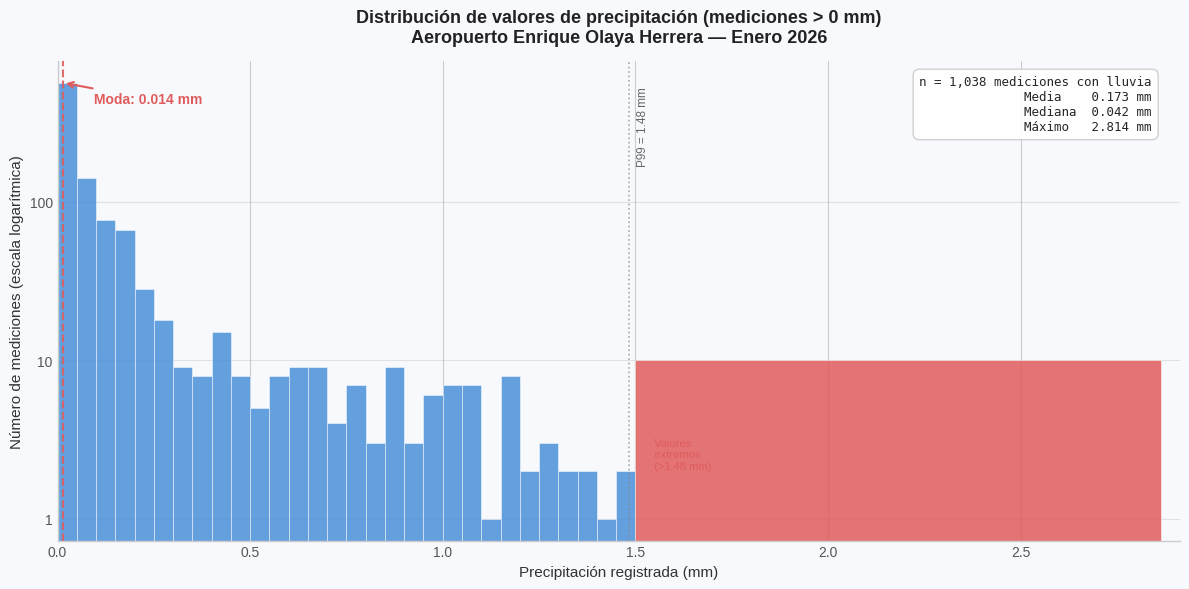


 2. Distribución de duraciones de eventos de lluvia 


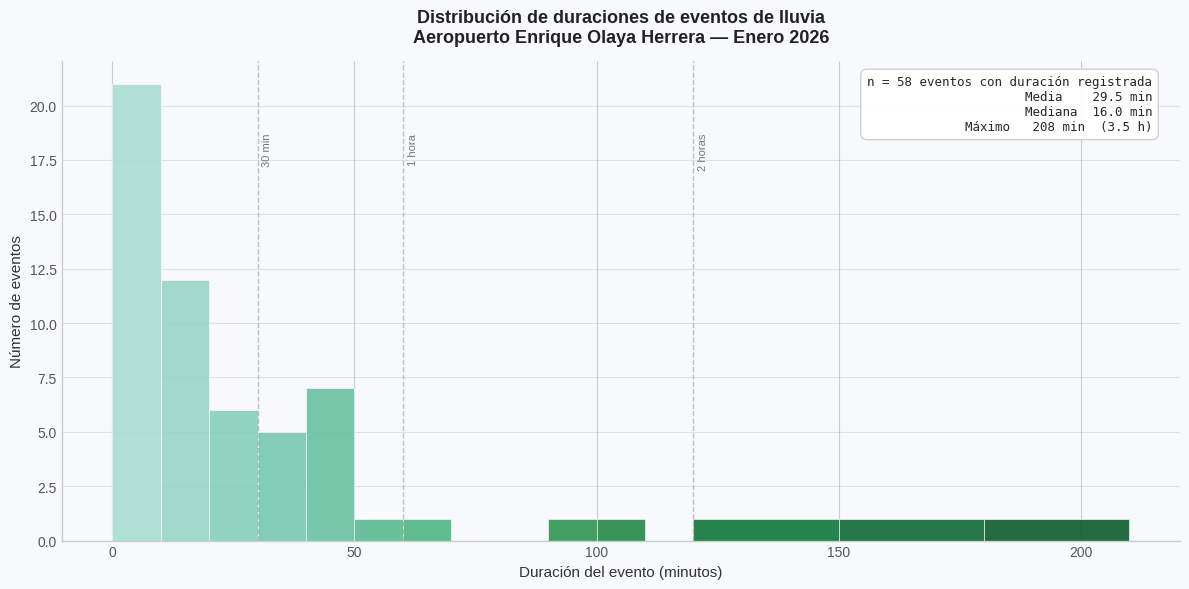

In [21]:
# @title parte 5: Visualizaciones

import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')



plt.style.use('seaborn-v0_8-whitegrid')


# Gráfico 1

print("\n 1. Distribución de valores de precipitación ")

lluvia_vals = df[df['ValorObservado'] > 0]['ValorObservado']
moda = lluvia_vals.mode().values[0]
p99 = np.percentile(lluvia_vals, 99)

bins_g1 = list(np.arange(0, p99 + 0.05, 0.05)) + [lluvia_vals.max() + 0.05]

fig, ax = plt.subplots(figsize=(12, 6))
fig.patch.set_facecolor('#F7F9FC')
ax.set_facecolor('#F7F9FC')

n, bins_out, patches = ax.hist(
    lluvia_vals, bins=bins_g1,
    color='#4A90D9', edgecolor='white', linewidth=0.4, alpha=0.85
)

# Bin de cola (>P99) en rojo para distinguir valores extremos
for i, (b0, _) in enumerate(zip(bins_out[:-1], bins_out[1:])):
    if b0 >= p99:
        patches[i].set_facecolor('#E05C5C')
        patches[i].set_alpha(0.85)

# Línea y etiqueta de la moda
moda_y = n[np.digitize(moda, bins_out) - 1]
ax.axvline(moda, color='#E05C5C', linestyle='--', linewidth=1.5, alpha=0.9)
ax.annotate(
    f'Moda: {moda:.3f} mm',
    xy=(moda, moda_y),
    xytext=(moda + 0.08, moda_y * 0.75),
    arrowprops=dict(arrowstyle='->', color='#E05C5C', lw=1.5),
    fontsize=10, color='#E05C5C', fontweight='bold'
)

# Línea punteada
ax.axvline(p99, color='#888', linestyle=':', linewidth=1.2, alpha=0.7)
ax.text(p99 + 0.02, ax.get_ylim()[1] * 0.9,
        f'P99 = {p99:.2f} mm',
        fontsize=8.5, color='#666', rotation=90, va='top')

# Etiqueta rojo
ax.text(p99 + 0.05, 2,
        f'  Valores\n  extremos\n  (>{p99:.2f} mm)',
        fontsize=8, color='#E05C5C', va='bottom')

# Cuadro de estadísticas
stats = (
    f"n = {len(lluvia_vals):,} mediciones con lluvia\n"
    f"Media    {lluvia_vals.mean():.3f} mm\n"
    f"Mediana  {lluvia_vals.median():.3f} mm\n"
    f"Máximo   {lluvia_vals.max():.3f} mm"
)
ax.text(0.975, 0.97, stats, transform=ax.transAxes,
        va='top', ha='right', fontsize=9,
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                  edgecolor='#CCCCCC', alpha=0.9),
        fontfamily='monospace')

ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{int(x):,}'))
ax.set_title(
    'Distribución de valores de precipitación (mediciones > 0 mm)\n'
    'Aeropuerto Enrique Olaya Herrera — Enero 2026',
    fontsize=13, fontweight='bold', pad=14, color='#222'
)
ax.set_xlabel('Precipitación registrada (mm)', fontsize=11, color='#333')
ax.set_ylabel('Número de mediciones (escala logarítmica)', fontsize=11, color='#333')
ax.set_xlim(0, lluvia_vals.max() + 0.1)
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_color('#CCCCCC')
ax.tick_params(colors='#555')
ax.grid(axis='y', alpha=0.3, color='#AAAAAA')

plt.tight_layout()
plt.show()


# Gráfico 2

print("\n 2. Distribución de duraciones de eventos de lluvia ")

if len(eventos_lluvia_df) > 0:
    eventos_con_dur = eventos_lluvia_df[eventos_lluvia_df['DuracionMin'] > 0]['DuracionMin']

    if len(eventos_con_dur) > 0:
        max_dur = eventos_con_dur.max()
        bins_g2 = list(range(0, 130, 10)) + list(range(150, int(max_dur) + 30, 30))

        fig, ax = plt.subplots(figsize=(12, 6))
        fig.patch.set_facecolor('#F7F9FC')
        ax.set_facecolor('#F7F9FC')

        n2, bins2, patches2 = ax.hist(
            eventos_con_dur, bins=bins_g2,
            color='#3A8C6E', edgecolor='white', linewidth=0.5, alpha=0.85
        )

        #  color:
        for i, p in enumerate(patches2):
            p.set_facecolor(plt.cm.BuGn(0.35 + 0.65 * (i / len(patches2))))
            p.set_edgecolor('white')
            p.set_linewidth(0.5)

        # Líneas de referencia en duraciones clave
        for duracion, etiqueta in [(30, '30 min'), (60, '1 hora'), (120, '2 horas')]:
            if duracion <= max_dur:
                ax.axvline(duracion, color='#999', linestyle='--', linewidth=1, alpha=0.6)
                ax.text(duracion + 1, ax.get_ylim()[1] * 0.85,
                        etiqueta, fontsize=8, color='#777', rotation=90, va='top')

        # Cuadro de estadísticas
        stats2 = (
            f"n = {len(eventos_con_dur):,} eventos con duración registrada\n"
            f"Media    {eventos_con_dur.mean():.1f} min\n"
            f"Mediana  {eventos_con_dur.median():.1f} min\n"
            f"Máximo   {max_dur:.0f} min  ({max_dur / 60:.1f} h)"
        )
        ax.text(0.975, 0.97, stats2, transform=ax.transAxes,
                va='top', ha='right', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white',
                          edgecolor='#CCCCCC', alpha=0.9),
                fontfamily='monospace')

        ax.set_title(
            'Distribución de duraciones de eventos de lluvia\n'
            'Aeropuerto Enrique Olaya Herrera — Enero 2026',
            fontsize=13, fontweight='bold', pad=14, color='#222'
        )
        ax.set_xlabel('Duración del evento (minutos)', fontsize=11, color='#333')
        ax.set_ylabel('Número de eventos', fontsize=11, color='#333')
        ax.spines[['top', 'right']].set_visible(False)
        ax.spines[['left', 'bottom']].set_color('#CCCCCC')
        ax.tick_params(colors='#555')
        ax.grid(axis='y', alpha=0.3, color='#AAAAAA')

        plt.tight_layout()
        plt.show()

    else:
        print("  No hay eventos con duración registrada para graficar.")
else:
    print("  No hay eventos de lluvia disponibles para graficar.")